# Question A2 (10 marks)

### In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on the training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

#### Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {64, 128, 256, 512}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection.


This might take a while to run, so plan your time carefully.

In [2]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1.To reduce repeated code, place your

- network (MLP defined in QA1)

- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [3]:
# YOUR CODE HERE

from common_utils import MLP, CustomDataset, loss_fn

In [4]:
from common_utils import split_dataset

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
columns_to_drop = ['filename', 'label']

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop=columns_to_drop, test_size=0.2, random_state=0)

2.Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly.

In [5]:
def generate_cv_folds_for_batch_sizes(parameters, X_train, y_train):
    """
    returns:
    X_train_scaled_dict(dict) where X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds.
    X_val_scaled_dict(dict) where X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds.
    y_train_dict(dict) where y_train_dict[batch_size] is a list of labels for the different folds
    y_val_dict(dict) where y_val_dict[batch_size] is a list of labels for the different folds
    """
    # YOUR CODE HERE
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    scaler = preprocessing.StandardScaler()

    kf = KFold(n_splits=5, shuffle=True, random_state=0)

    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []

        for train_idx, val_idx in kf.split(X_train):
            X_train_fold = X_train[train_idx]
            X_val_fold = X_train[val_idx]
            y_train_fold = y_train[train_idx]
            y_val_fold = y_train[val_idx]
            
            # do scaler with respect to each fold
            X_train_fold_scaled = scaler.fit_transform(X_train_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            X_train_scaled_dict[batch_size].append(X_train_fold_scaled)
            X_val_scaled_dict[batch_size].append(X_val_fold_scaled)
            y_train_dict[batch_size].append(y_train_fold)
            y_val_dict[batch_size].append(y_val_fold)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

batch_sizes = [64, 128, 256, 512]
X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = generate_cv_folds_for_batch_sizes(batch_sizes, X_train.to_numpy(), y_train)

3.Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation.

In [6]:
# YOUR CODE HERE
from common_utils import EarlyStopper, train_loop, val_loop

def find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, param_name):
    no_features = 77
    no_hiddens = 128
    no_labels = 1
    lr = 0.001
    fold=5
    
    accuracies = {}
    last_epoch_times = {}

    for batch_size in batch_sizes:
        accuracy = []
        last_epoch_time = []
        print(f"batch size: {batch_size}")

        for i in range(fold):
            no_epochs = 100

            model = MLP(no_features, no_hiddens, no_labels)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            train_dataset = CustomDataset(X_train_scaled_dict[batch_size][i], y_train_dict[batch_size][i])
            val_dataset = CustomDataset(X_val_scaled_dict[batch_size][i], y_val_dict[batch_size][i])
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

            early_stopper = EarlyStopper(patience=3, min_delta=0)

            for epoch in range(no_epochs):
                start_time = time.time()

                train_loop(train_dataloader, model, loss_fn, optimizer)
        
                val_loss, val_acc = val_loop(val_dataloader, model, loss_fn)

                end_time = time.time()

                if early_stopper.early_stop(val_loss): 
                    print(f"Early stopping at epoch {epoch + 1}!")
                    break
            
            accuracy.append(val_acc)
            last_epoch_time.append(end_time - start_time)
            print(f"experiment {i + 1}: accuracy: {val_acc:>4f}; last epoch time {end_time - start_time:>4f}")

        accuracies[batch_size] = accuracy 
        last_epoch_times[batch_size] = last_epoch_time
        print(f"batch size {batch_size}: mean accuracy: {sum(accuracies[batch_size]) / fold:>4f}; mean last epoch time {sum(last_epoch_times[batch_size]) / fold:>4f}")

    return accuracies, last_epoch_times

batch_sizes = [64, 128, 256, 512]
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict, batch_sizes, 'batch_size')

batch size: 64
Early stopping at epoch 30!
experiment 1: accuracy: 0.762571; last epoch time 0.192869
Early stopping at epoch 17!
experiment 2: accuracy: 0.724728; last epoch time 0.193477
Early stopping at epoch 31!
experiment 3: accuracy: 0.754277; last epoch time 0.158350
Early stopping at epoch 18!
experiment 4: accuracy: 0.725765; last epoch time 0.169449
Early stopping at epoch 25!
experiment 5: accuracy: 0.762571; last epoch time 0.159408
batch size 64: mean accuracy: 0.745982; mean last epoch time 0.174711
batch size: 128
Early stopping at epoch 33!
experiment 1: accuracy: 0.778123; last epoch time 0.099476
Early stopping at epoch 24!
experiment 2: accuracy: 0.734578; last epoch time 0.100492
Early stopping at epoch 28!
experiment 3: accuracy: 0.748574; last epoch time 0.098601
Early stopping at epoch 25!
experiment 4: accuracy: 0.725246; last epoch time 0.098140
Early stopping at epoch 31!
experiment 5: accuracy: 0.754277; last epoch time 0.098016
batch size 128: mean accuracy

In [7]:
cross_validation_accuracies

{64: [0.7625712804561949,
  0.7247278382581649,
  0.7542768273716952,
  0.7257646448937273,
  0.7625712804561949],
 128: [0.7781233799896319,
  0.7345775012960083,
  0.7485743908761016,
  0.7252462415759461,
  0.7542768273716952],
 256: [0.7563504406428201,
  0.7236910316226024,
  0.7268014515292898,
  0.71850699844479,
  0.7579056505961638],
 512: [0.7309486780715396,
  0.7148781752203214,
  0.7268014515292898,
  0.7195438050803525,
  0.7128045619491965]}

4.Plot scatterplot of mean cross validation accuracies for the different batch sizes.

In [8]:
# YOUR CODE HERE
mean_accuracies = [sum(cross_validation_accuracies[batch_size]) / len(cross_validation_accuracies[batch_size]) for batch_size in batch_sizes]
mean_last_epoch_times = [sum(cross_validation_times[batch_size]) / len(cross_validation_times[batch_size]) for batch_size in batch_sizes]

def plot_accuracies(batch_sizes, accuracies):
    plt.scatter(batch_sizes, accuracies, color='blue')
    plt.title('Mean Cross-Validation Accuracies for Different Batch Sizes')
    plt.xlabel('Batch Size')
    plt.ylabel('Mean Accuracy')
    plt.grid(True)
    plt.show()


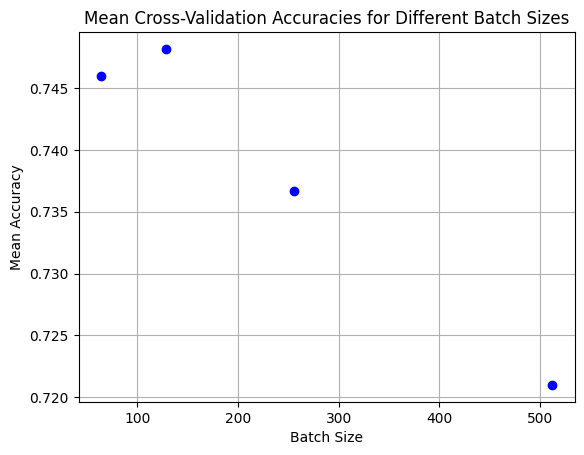

In [9]:
plot_accuracies(batch_sizes, mean_accuracies)

4.Create a table of time taken to train the network on the last epoch against different batch sizes. Select the optimal batch size and state a reason for your selection.

In [10]:
df = pd.DataFrame({'Batch Size': batch_sizes,
                   'Last Epoch Time': mean_last_epoch_times
                  })
df

,Batch Size,Last Epoch Time
0,64,0.174711
1,128,0.098945
2,256,0.070778
3,512,0.054278


In [11]:
# YOUR CODE HERE
optimal_batch_size = 128
reason = "128 is a number in between. Smaller batchsize help it easier to escape overfitting and local minima but introduce noise and take longer to train, while larger could lead to overfitting but have smoother convergence. 128 is in between and could balance the 2 factors well."